In [1]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

In [2]:
import time

import numpy as np

from rmrl.experiments.configurations import *
from rmrl.experiments.with_transfer import WithTransferExperiment
from rmrl.experiments.runner import ExperimentsRunner
from rmrl.utils.misc import sha3_hash

import matplotlib.pyplot as plt

In [78]:
def get_simple_exp(with_geco):
    return WithTransferExperiment(
        cfg=ExperimentConfiguration(
            env=SupportedEnvironments.GRID_NAVIGATION,
            cspace=ContextSpaces.FIXED_ENTITIES,
            alg=Algos.PPO,
            mods=[Mods.AS, Mods.RS] + ([Mods.GECO] if with_geco else []),
            rm_kwargs={},
            model_kwargs={},
            alg_kwargs={
                # 'learning_starts': 0,
                # 'exploration_fraction': 0.5,
                # 'n_steps': 128
            },
            seed=42
        ),
        total_timesteps=2e5,
        dump_dir=('no ' if not with_geco else 'with ') + 'geco BAD_TF',
        verbose=1,
        # eval_freq=100,
        # min_evals=500
    )

no_geco_exp = get_simple_exp(with_geco=False)
with_geco_exp = get_simple_exp(with_geco=True)

In [20]:
[(src, tgt)] = ExperimentsRunner.load_or_sample_contexts(exp=no_geco_exp,
                                                           num_samples=1,
                                                           sample_seed=24)
src_name = sha3_hash(src)
tgt_name = sha3_hash(tgt)

In [32]:
src_env = no_geco_exp.get_env_for_context(src)
src_env.reset()
print('src context')
src_env.render()

tgt_env = no_geco_exp.get_env_for_context(tgt)
tgt_env.reset()
print('tgt context')
tgt_env.render()

src context
+-----------------------+
| : |F: | : | : | : |F: |
| :P| : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (4, 3), Engine: ON, Collided: False, Step: 0/200, ALIVE
Passenger0-YELLOW: Location: (1, 1), Destination: (-1, -1)
Env done: False

tgt context
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : :P| : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 10), Engine: ON, Collided: False, Step: 0/200, ALIVE
Passenger0-YELLOW: Location: (3, 5), Destination: (-1, -1)
Env done: False



In [79]:
no_transfer_res = np.load(no_geco_exp.eval_log_dir / tgt_name / 'evaluations.npz')
with_transfer_res = np.load(no_geco_exp.eval_log_dir / 
                            f'{tgt_name}_transfer_from_{src_name}' / 
                            'evaluations.npz')

geco_no_transfer_res = np.load(with_geco_exp.eval_log_dir / tgt_name / 'evaluations.npz')
geco_with_transfer_res = np.load(with_geco_exp.eval_log_dir / 
                            f'{tgt_name}_transfer_from_{src_name}' / 
                            'evaluations.npz')

In [6]:
list(no_transfer_res.keys())

['timesteps', 'results', 'ep_lengths']

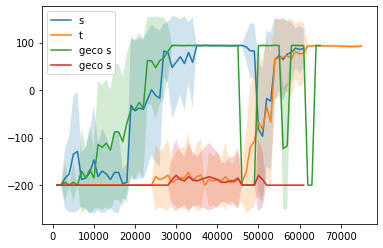

In [80]:
def plotter(npz, label):
    x = npz['timesteps']
    ys = npz['results']
    means = np.mean(ys, axis=-1)
    stds = np.std(ys, axis=-1)
    
    plt.plot(x, means, label=label)
    plt.fill_between(x, means - stds, means + stds, alpha=0.2)


plt.figure()
# plt.plot(no_transfer_res['timesteps'], np.mean(no_transfer_res['results'], axis=-1), label='s')
# plt.plot(with_transfer_res['timesteps'], np.mean(with_transfer_res['results'], axis=-1), label='t')
# plt.xlabel('steps')
# plt.ylabel('mean reward')
# plt.plot(geco_no_transfer_res['timesteps'], np.mean(geco_no_transfer_res['results'], axis=-1), label='GECO s')
# plt.plot(geco_with_transfer_res['timesteps'], np.mean(geco_with_transfer_res['results'], axis=-1), label='GECO t')
# plt.xlim(40_000, 50_000)
plotter(no_transfer_res, label='s')
plotter(with_transfer_res, label='t')
plotter(geco_no_transfer_res, label='geco s')
plotter(geco_with_transfer_res, label='geco s')
plt.legend()

In [68]:
df = with_geco_exp.load_tb()#tgt_name + '_1')

In [70]:
df[f'{tgt_name}_1']

,eval/mean_ep_length,eval/mean_reward,train/approx_kl,train/clip_fraction,train/clip_range,train/entropy_loss,train/explained_variance,train/learning_rate,train/loss,train/policy_gradient_loss,train/value_loss,rollout/ep_len_mean,rollout/ep_rew_mean,rollout/ep_true_rew_mean,time/fps
epoch,,,,,,,,,,,,,,,
1000,200.000000,-200.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,200.000000,-200.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000,196.020004,-194.020004,0.012273,0.119092,0.2,-1.600333,-0.046143,0.0003,-0.033060,-0.010039,0.091798,NaN,NaN,NaN,NaN
4000,200.000000,-200.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5000,196.020004,-194.020004,0.011615,0.103857,0.2,-1.579441,0.008492,0.0003,0.115369,-0.008307,0.256509,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.02,-0.6344,90.980003,28.0
32768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.62,-0.4166,93.379997,34.0
40960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.21,-0.3819,93.790001,41.0
